<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-4" data-toc-modified-id="Project-4-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project 4</a></span></li><li><span><a href="#Electricity-Prediction" data-toc-modified-id="Electricity-Prediction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Electricity Prediction</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Modelization" data-toc-modified-id="Modelization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modelization</a></span><ul class="toc-item"><li><span><a href="#Testing-different-algorithms" data-toc-modified-id="Testing-different-algorithms-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Testing different algorithms</a></span></li><li><span><a href="#Plotting-residue" data-toc-modified-id="Plotting-residue-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Plotting residue</a></span></li></ul></li><li><span><a href="#Hyperparameters-tuning-for-best-models" data-toc-modified-id="Hyperparameters-tuning-for-best-models-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Hyperparameters tuning for best models</a></span><ul class="toc-item"><li><span><a href="#Grid-Search-CV" data-toc-modified-id="Grid-Search-CV-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Grid Search CV</a></span></li><li><span><a href="#Parameters-optimization-1/1" data-toc-modified-id="Parameters-optimization-1/1-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Parameters optimization 1/1</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Features importance</a></span></li></ul></li><li><span><a href="#CO2-prediction" data-toc-modified-id="CO2-prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CO2 prediction</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Modelization" data-toc-modified-id="Modelization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modelization</a></span><ul class="toc-item"><li><span><a href="#Testing-different-algorithms" data-toc-modified-id="Testing-different-algorithms-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Testing different algorithms</a></span></li><li><span><a href="#Residue-plotting" data-toc-modified-id="Residue-plotting-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Residue plotting</a></span></li></ul></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Features importance</a></span></li></ul></li><li><span><a href="#Energy-Stars-score-influence" data-toc-modified-id="Energy-Stars-score-influence-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy Stars score influence</a></span><ul class="toc-item"><li><span><a href="#Energy" data-toc-modified-id="Energy-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Energy</a></span></li><li><span><a href="#CO2" data-toc-modified-id="CO2-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CO2</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Improvements" data-toc-modified-id="Improvements-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Improvements</a></span></li><li><span><a href="#OTHER" data-toc-modified-id="OTHER-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>OTHER</a></span></li></ul></div>

# Project 4

The objectif of this project is to predict the CO2 emissions and electricity consumption of buildings in Seatle.  
The project is divided into two notebooks:  
- One with data exploratory analysis, where the data will be transformed  
- One with the prediction  
***
The following notebook is dedicated to the prediction of the CO2 and electricity. It is divided into two parts: the Electricity prediction and the CO2 emission prediction. Lastly, we will study the importance of the EnergyScore feature.

In [1]:
#Data manipulation
import pandas as pd
import numpy as np

#Graphical
# %pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection, preprocessing
# !pip3 install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

#Progression
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("data/cleaned_dataframe.csv")

#Get a DF for electricity study and another for the CO2
dfe = df.drop(columns='GHGEmissions(MetricTonsCO2e)')
dfc = df.drop(columns="SiteEnergyUse(kBtu)")

# Electricity Prediction

## Data Preprocessing 

In [3]:
# %reset

During the data exploratory, we notice that the features don't have the same order of magnitude, hence we have to standardize the data. Plus the electricity and CO2 are very disparate, we will use the log() to reduce it. 

In [3]:
#All features
X = dfe.iloc[:,:-1]
#Use the log function on the electricity, since it has a huge disparity
y = dfe.iloc[:,-1].map(lambda x: np.log(x+1))

seed = 42

#Split the dataset and standardization
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = seed)
std_scaler = preprocessing.StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [4]:
X_train_std.shape

(4671, 100)

## Modelization

We will first study the result from different algorithms, then conduct a hyperparameter tuning for the two best algorithms.
The baseline will be a simple ridge regression.

In [5]:
def compute_output(clf, X_train, y_train, X_test):
    """Fit the classifier and predict the output"""
    clf.fit(X_train,y_train)
    y_pred_fnc = clf.predict(X_test)
    return y_pred_fnc

### Testing different algorithms

In [6]:
#Electricity prediction
classifiers = []

classifiers.append(RandomForestRegressor(n_jobs=-1, n_estimators=100,random_state=seed,max_depth=10))
classifiers.append(xgb.XGBRegressor(objective="reg:squarederror",n_estimators=100, random_state=seed))
classifiers.append(GradientBoostingRegressor(n_estimators=100, random_state=seed))
classifiers.append(DecisionTreeRegressor())
classifiers.append(KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2))
classifiers.append(svm.SVR(gamma="auto"))
classifiers.append(svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
classifiers.append(linear_model.Ridge())
# classifiers.append(linear_model.LinearRegression())

y_pred_all = []
error_all_r2 = []
error_all_rmse = []

for i,clf in enumerate(classifiers):
    y_pred_all.append(compute_output(clf,X_train_std, y_train, X_test_std))
    error_all_r2.append(metrics.r2_score(y_test, y_pred_all[i]))
    error_all_rmse.append(metrics.mean_squared_error(y_test, y_pred_all[i]))

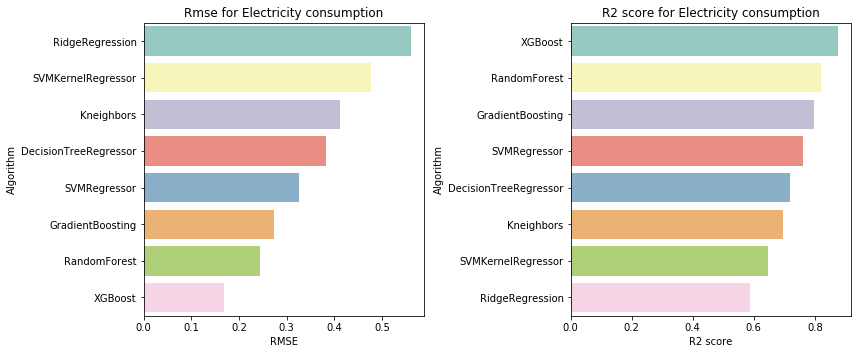

In [7]:
#Plot results
def draw_result(results,x_label,algorithm_name,title):
    name = str(results)
    cv_res = pd.DataFrame({'Result':results,"Algorithm":algorithm_name})
    new_idx = cv_res.Result.sort_values(ascending=False).index
    cv_res = cv_res.reindex(new_idx)
    g = sns.barplot("Result","Algorithm",data = cv_res, palette="Set3",orient = "h")
    g.set_xlabel(x_label)
#     g.set(xlim=(0,2))#max(cv_res["R2_score"]
    g = g.set_title(title) 
    
algo = ["RandomForest","XGBoost","GradientBoosting","DecisionTreeRegressor","Kneighbors",
        "SVMRegressor","SVMKernelRegressor","RidgeRegression"]#,"LinearRegression"]

figure = plt.figure(figsize=(12,5))
plt.subplot(121)
draw_result(error_all_rmse,"RMSE",algo,"Rmse for Electricity consumption")
plt.subplot(122)
draw_result(error_all_r2,"R2 score",algo,"R2 score for Electricity consumption")
figure.tight_layout(pad=1.0)

As we can see from the above graph, we have very good result already due to our detailed data exploratory. We can see that the XGBoost is three time more accurate than our baseline, which is the ridge regression.  
In order to compare the prediction with the actual value, we will study the residue between the two curves.

### Plotting residue

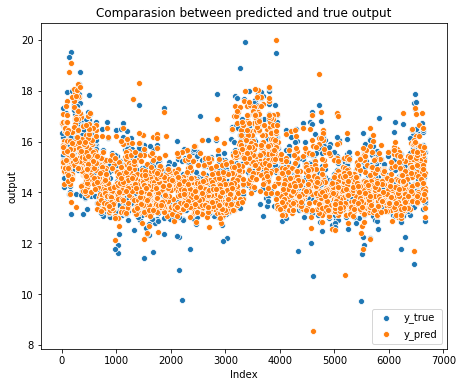

In [72]:
#Compare results
y_f = pd.DataFrame({"y_true":y_test,"y_pred":y_pred_all[1]})
y_f['residue'] = y_f['y_true'] - y_f['y_pred']
y_f['index'] = y_f.index

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)

sns.scatterplot(x='index', y='y_true',data=y_f,ax=ax1,label='y_true')
sns.scatterplot(x='index', y='y_pred',data=y_f,ax=ax1,label='y_pred')
ax1.legend(loc='lower right')
ax1.set_title('Comparasion between predicted and true output')
ax1.set_xlabel('Index')
ax1.set_ylabel('output')
plt.show()

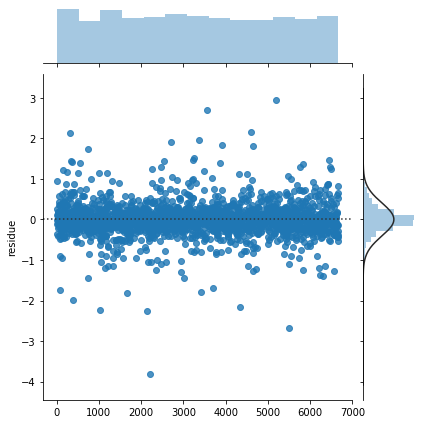

In [73]:
sns.jointplot(y_f.index,y_f.residue, kind="resid")
plt.show()

As we can see, the residue tends to have a normal distribution around 0. The RMSE is only about 1% to the means of the electrical consumption, the XGBoost and random forest give really good prediction for this feature.

In [75]:
res = pd.DataFrame({"Algorithm":algo,"Rmse_score_elec":error_all_rmse})
# new_idx = res.Rmse_score_elec.sort_values(ascending=True).index
# res = res.reindex(new_idx)
res = res[:2]
print(res)

      Algorithm  Rmse_score_elec
0  RandomForest         0.244502
1       XGBoost         0.168866


## Hyperparameters tuning for best models

I performed a grid search optimization for RandomForest, XGboost regressor models.  
In order to get a better understanding of hyperparameters optimization, I study the hyperparameters one by one.

### Grid Search CV

In [12]:
# # Grid Search CV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 7)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(3, 30, num = 10)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [3, 5, 7, 10, 15]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [3, 5, 10, 15]
# # Method of selecting samples for training each tree
# # bootstrap = [True, False]

# Create the random grid
rf_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# rfr = RandomForestRegressor()

# gs_rfr = model_selection.RandomizedSearchCV(estimator = rfr,scoring='neg_mean_squared_error', param_distributions = rf_param_grid, n_iter = 100, cv = 3, 
#                                verbose=10, random_state=42, n_jobs = 4)

# # gs_rfr = model_selection.GridSearchCV(rfr,param_grid = rf_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs= -1)

# gs_rfr.fit(X_train_std,y_train)
# print(gs_rfr.best_params_)

# # Best score
# print(gs_rfr.best_score_)

{'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}

### Parameters optimization 1/1

**min_samples_split**

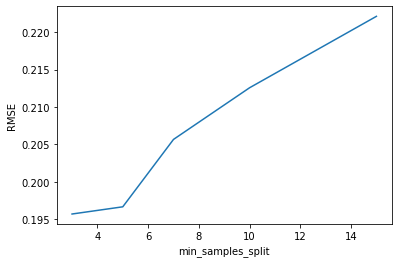

In [16]:
min_samples_split = [3, 5, 7, 10, 15]
rmse_test = []
for i in tqdm(min_samples_split):
    rf = RandomForestRegressor(min_samples_split=i,n_estimators=100)
    rf.fit(X_train_std, y_train)
    test_pred = rf.predict(X_test_std)
    rmse_test.append(metrics.mean_squared_error(y_test,test_pred))

ax = sns.lineplot(x=min_samples_split,y=rmse_test)
ax.set_xlabel('min_samples_split')
ax.set_ylabel('RMSE')
plt.show()
# plt.plot(min_samples_split,rmse_test)

**min_samples_leaf**

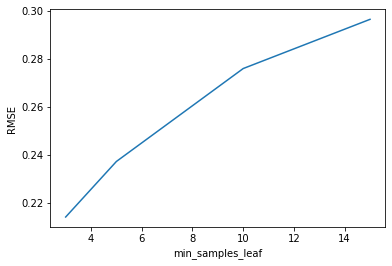

In [17]:
min_samples_leaf = [3, 5, 10, 15]
rmse_test = []
for i in tqdm(min_samples_leaf):
    rf = RandomForestRegressor(min_samples_leaf=i,n_estimators=100)
    rf.fit(X_train_std, y_train)
    test_pred = rf.predict(X_test_std)
    rmse_test.append(metrics.mean_squared_error(y_test,test_pred))

ax = sns.lineplot(x=min_samples_leaf,y=rmse_test)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('RMSE')
plt.show()

**n_estimators**

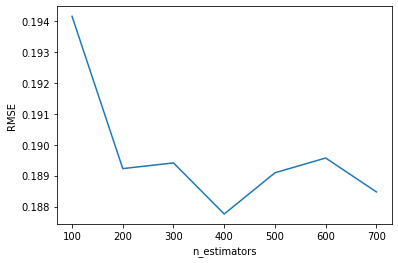

In [14]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 7)]

rmse_test = []
for i in tqdm(n_estimators):
    rf = RandomForestRegressor(n_estimators=i)
    rf.fit(X_train_std, y_train)
    test_pred = rf.predict(X_test_std)
    rmse_test.append(metrics.mean_squared_error(y_test,test_pred))

ax = sns.lineplot(x=n_estimators,y=rmse_test)
ax.set_xlabel('n_estimators')
ax.set_ylabel('RMSE')
plt.show()

**max_depth**

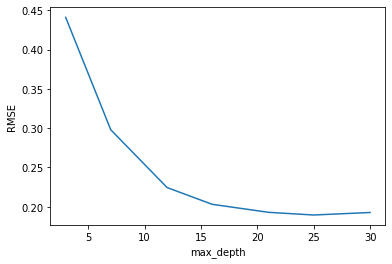

In [15]:
max_depth = [int(x) for x in np.linspace(3, 30, num = 7)]

rmse_test = []
for i in tqdm(max_depth):
    rf = RandomForestRegressor(max_depth=i,n_estimators=100)
    rf.fit(X_train_std, y_train)
    test_pred = rf.predict(X_test_std)
    rmse_test.append(metrics.mean_squared_error(y_test,test_pred))

ax = sns.lineplot(x=max_depth,y=rmse_test)
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
plt.show()

**XGBoost optimization**

In [18]:
# #Extrem Gradient Boosting Tuning

# xgb_r = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     n_estimators=1000,
#     max_depth=5,
#     min_child_weight=1,
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)

# xgb_param_grid = {'colsample_bytree': [0.3,0.5,0.7],'learning_rate': [0.3,0.1,0.07],
#             'max_depth': [3,5,7], 'alpha': [5,10,15]}

# gs_xgb = model_selection.GridSearchCV(xgb_r, param_grid=xgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

# gs_xgb.fit(X_train_std,y_train)

# xgb_best = gs_xgb.best_estimator_
# print(gs_xgb.best_params_)

# # Best score
# print(gs_xgb.best_score_)

{'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 50, 'n_estimators': 300}

### Results

Random Forest Best Params  
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 25}

XGBoost Best Params  
{'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 50, 'n_estimators': 300}

In [76]:
RMSE_score_opti_elec = []

#Results with the best params
rfr_optie = RandomForestRegressor(max_depth=25,min_samples_leaf=3,min_samples_split=2,
                                  n_estimators=600,max_features='auto',)
rfr_optie.fit(X_train_std,y_train)

xgb_optie = XGBRegressor(objective="reg:squarederror",learning_rate=0.05, random_state=42, 
                        max_depth= 10, max_features= 0.1, min_samples_leaf= 50, n_estimators=300)
xgb_optie.fit(X_train_std,y_train)

RMSE_score_opti_elec.append(metrics.mean_squared_error(y_test,rfr_optie.predict(X_test_std)))
RMSE_score_opti_elec.append(metrics.mean_squared_error(y_test,xgb_optie.predict(X_test_std)))

res["Rmse_score_opti_elec"] = RMSE_score_opti_elec

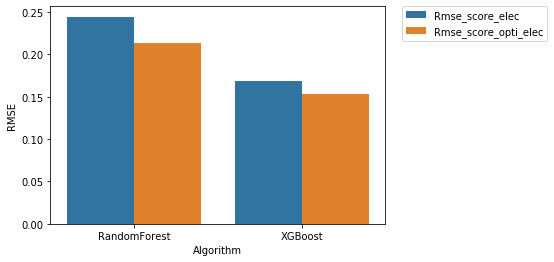

In [77]:
#Compare results
fig, ax1 = plt.subplots(nrows=1,ncols=1)

tidy = res.melt(id_vars='Algorithm').rename(columns=str.title)
tidy.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Features importance

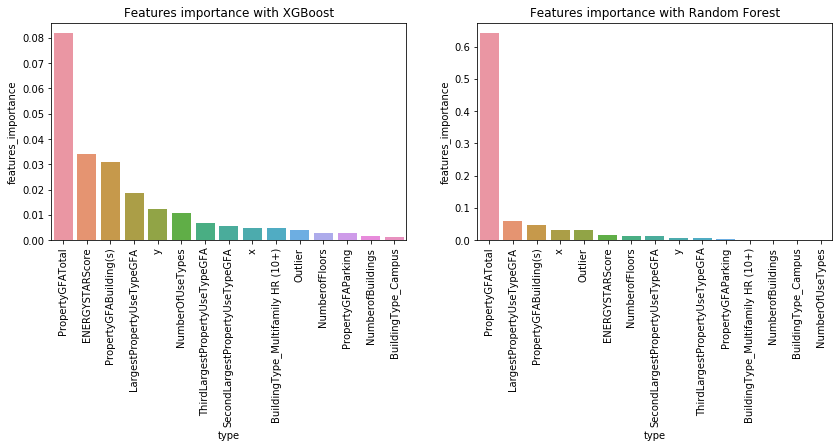

In [62]:
#Features importance
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

d1 = pd.DataFrame(xgb_optie.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d2 = pd.DataFrame(rfr_optie.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d1['type'] = d1.index
d1.columns=['features_importance','type']

d2['type'] = d2.index
d2.columns=['features_importance','type']

g1 = sns.barplot(x='type',y='features_importance',data=d1,ax=ax1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set_title('Features importance with XGBoost')

g2 = sns.barplot(x='type',y='features_importance',data=d2,ax=ax2)
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set_title('Features importance with Random Forest')

plt.show()

# CO2 prediction

## Data Preprocessing

In [22]:
#All features
X1 = dfc.iloc[:,:-1]
#Use the log function on the output due to the outliers
y1 = dfc.iloc[:,-1].map(lambda x: np.log(x+1))

#Split the dataset and standardization
X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(X1, y1, test_size = 0.3)
std_scaler1 = preprocessing.StandardScaler()
X_train_std1 = std_scaler1.fit_transform(X_train1)
X_test_std1 = std_scaler1.transform(X_test1)

## Modelization

### Testing different algorithms

In [23]:
#CO2 prediction
classifiers1 = []

classifiers1.append(RandomForestRegressor(n_jobs=-1, n_estimators=100,max_depth=10))
classifiers1.append(xgb.XGBRegressor(objective="reg:squarederror", random_state=42))
classifiers1.append(GradientBoostingRegressor(n_estimators=100))
classifiers1.append(DecisionTreeRegressor())
classifiers1.append(KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2))
classifiers1.append(svm.SVR(gamma="auto"))
classifiers1.append(svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
classifiers1.append(linear_model.Ridge())
# classifiers1.append(linear_model.LinearRegression())

y_pred_all1 = []
error_all_rmse1 = []
error_all_r21 = []

for i,clf in enumerate(classifiers1):
    y_pred_all1.append(compute_output(clf,X_train_std1, y_train1, X_test_std1))
    error_all_rmse1.append(metrics.mean_squared_error(y_test1, y_pred_all1[i]))
    error_all_r21.append(metrics.r2_score(y_test1, y_pred_all1[i]))

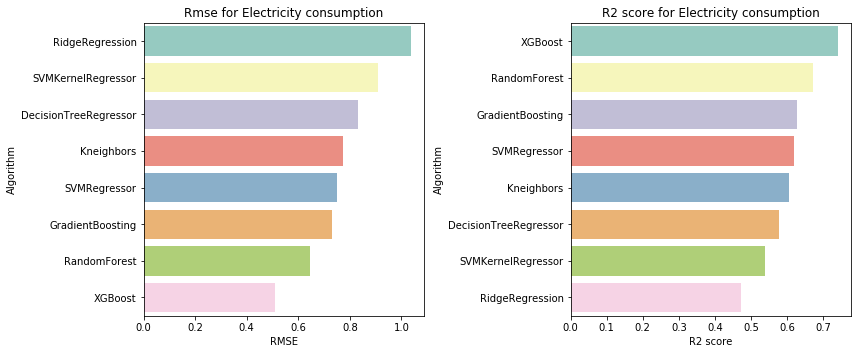

In [24]:
#Results for CO2
figure = plt.figure(figsize=(12,5))
plt.subplot(121)
draw_result(error_all_rmse1,"RMSE",algo,"Rmse for Electricity consumption")
plt.subplot(122)
draw_result(error_all_r21,"R2 score",algo,"R2 score for Electricity consumption")
figure.tight_layout(pad=1.0)

In [25]:
res1 = pd.DataFrame({"Algorithm":algo,"Rmse_score_co2":error_all_rmse1})
# new_idx = res1.Rmse_score_co2.sort_values(ascending=True).index
# res1 = res1.reindex(new_idx)
res1 = res1[:2]
res1

,Algorithm,Rmse_score_co2
0,RandomForest,0.644021
1,XGBoost,0.510780


### Residue plotting

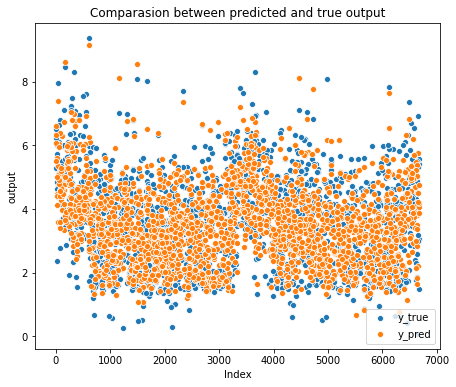

In [78]:
#Compare results
y_f1 = pd.DataFrame({"y_true":y_test1,"y_pred":y_pred_all1[1]})
y_f1['residue'] = y_f1['y_true'] - y_f1['y_pred']
y_f1['index'] = y_f1.index

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)

sns.scatterplot(x='index', y='y_true',data=y_f1,ax=ax1,label='y_true')
sns.scatterplot(x='index', y='y_pred',data=y_f1,ax=ax1,label='y_pred')
ax1.legend(loc='lower right')
ax1.set_title('Comparasion between predicted and true output')
ax1.set_xlabel('Index')
ax1.set_ylabel('output')
plt.show()

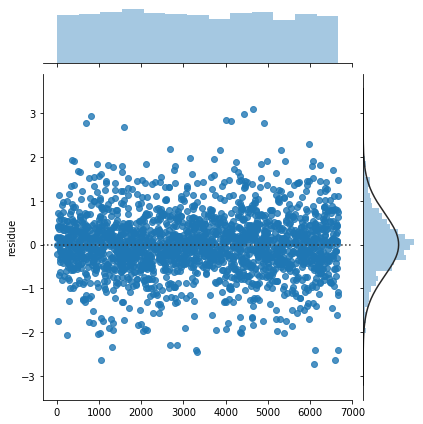

In [79]:
#Plot residue
sns.jointplot(y_f1.index,y_f1.residue, kind="resid")
plt.show()

## Optimization

In [29]:
# # Grid Search CV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 7)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 10, 15, 100]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [5, 10, 15]
# # Method of selecting samples for training each tree
# # bootstrap = [True, False]

# # Create the random grid
# rf_param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# rfr = RandomForestRegressor()

# rf_random = model_selection.RandomizedSearchCV(estimator = rfr, param_distributions = rf_param_grid, n_iter = 100, cv = 3, 
#                                verbose=2, random_state=42, n_jobs = -1)

# # gs_rfr = model_selection.GridSearchCV(rfr,param_grid = rf_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs= -1)

# rf_random.fit(X_train_std1,y_train1)

# rfr_best = gs_rfr.best_estimator_
# print(gs_rfr.best_params_)

# # Best score
# print(gs_rfr.best_score_)

n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 19

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
1. Fix learning rate and number of estimators 
2. Tree based parameters: max_depth and min_weight
3. Tune gamma
4. Subsample and colsample_bytree
5. Regularization parameters: alpha

In [30]:
# #Extrem Gradient Boosting Tuning

# xgb_r = xgb.XGBRegressor(
#     objective="reg:squarederror")

# xgb_param_grid = {'colsample_bytree': [0.3,0.5,0.7],'learning_rate': [0.3,0.1,0.07],
#             'max_depth': [3,5,7], 'alpha': [5,10,15]}

# gs_xgb = model_selection.GridSearchCV(xgb_r, param_grid=xgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=4)

# gs_xgb.fit(X_train_std1,y_train1)

# xgb_best = gs_xgb.best_estimator_
# print(gs_xgb.best_params_)

# # Best score
# print(gs_xgb.best_score_)

{'alpha': 5, 'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 7}

**Results**

In [28]:
#Results for CO2
RMSE_score_opti_co2 = []

#Results with the best params
rfr_optic = RandomForestRegressor(max_depth=22,min_samples_leaf=2,min_samples_split=2,n_estimators=600)
rfr_optic.fit(X_train_std1,y_train1)
RMSE_score_opti_co2.append(metrics.mean_squared_error(y_test1,rfr_optic.predict(X_test_std1)))

xgb_optic = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, alpha=3,colsample_bytree=0.7,
                             learning_rate=0.3, max_depth=7)
xgb_optic.fit(X_train_std1,y_train1)
RMSE_score_opti_co2.append(metrics.mean_squared_error(y_test1,xgb_optic.predict(X_test_std1)))

res1["Rmse_score_opti_co2"] = RMSE_score_opti_co2

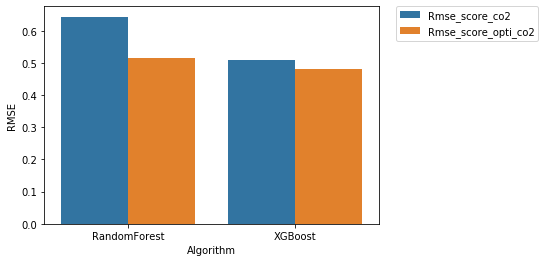

In [29]:
#Compare results
fig, ax1 = plt.subplots()

tidy1 = res1.melt(id_vars='Algorithm').rename(columns=str.title)
tidy1.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy1, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Features importance

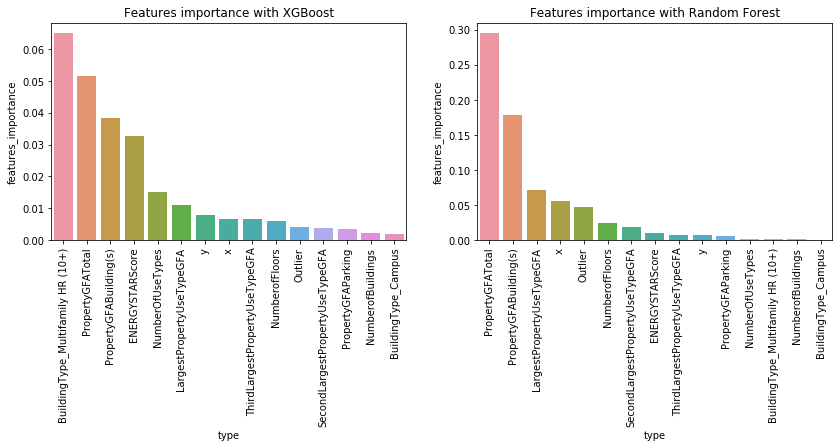

In [63]:
#Features importance
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

d1 = pd.DataFrame(xgb_optic.feature_importances_[:15],index=X_train1.columns[:15]).sort_values(
    by=0,ascending=False)

d2 = pd.DataFrame(rfr_optic.feature_importances_[:15],index=X_train1.columns[:15]).sort_values(
    by=0,ascending=False)

d1['type'] = d1.index
d1.columns=['features_importance','type']

d2['type'] = d2.index
d2.columns=['features_importance','type']

g1 = sns.barplot(x='type',y='features_importance',data=d1,ax=ax1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set_title('Features importance with XGBoost')

g2 = sns.barplot(x='type',y='features_importance',data=d2,ax=ax2)
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set_title('Features importance with Random Forest')

plt.show()

# Energy Stars score influence

In this section, we will study the influence of the EnergyStarScore on the prediction of the electricity and CO2 prediction. To do so, we remove this feature and compare the RMSE with and without the feature.

## Energy

In [31]:
#Influence on the Electricity
X_train_e = X_train.drop(columns="ENERGYSTARScore")
X_test_e = X_test.drop(columns="ENERGYSTARScore")

std_scaler2 = preprocessing.StandardScaler()
X_train_stde = std_scaler2.fit_transform(X_train_e)
X_test_stde = std_scaler2.transform(X_test_e)

rfr_optie.fit(X_train_stde,y_train)

# xgbr_e = xgb.XGBRegressor()
xgb_optie.fit(X_train_stde,y_train)

RMSE_score_opti_e_nrj = []

RMSE_score_opti_e_nrj.append(metrics.mean_squared_error(y_test,rfr_optie.predict(X_test_stde)))
RMSE_score_opti_e_nrj.append(metrics.mean_squared_error(y_test,xgb_optie.predict(X_test_stde)))

res["Rmse_score_opti_e_nrj"] = RMSE_score_opti_e_nrj

In [32]:
res

,Algorithm,Rmse_score_elec,Rmse_score_opti_elec,Rmse_score_opti_e_nrj
0,RandomForest,0.244502,0.212473,0.236948
1,XGBoost,0.168866,0.153687,0.182737


11.52 % increase in RMSE without the ENERYSTARSCORE with a Random Forest
18.90 % increase in RMSE without the ENERYSTARSCORE with a XGBoost


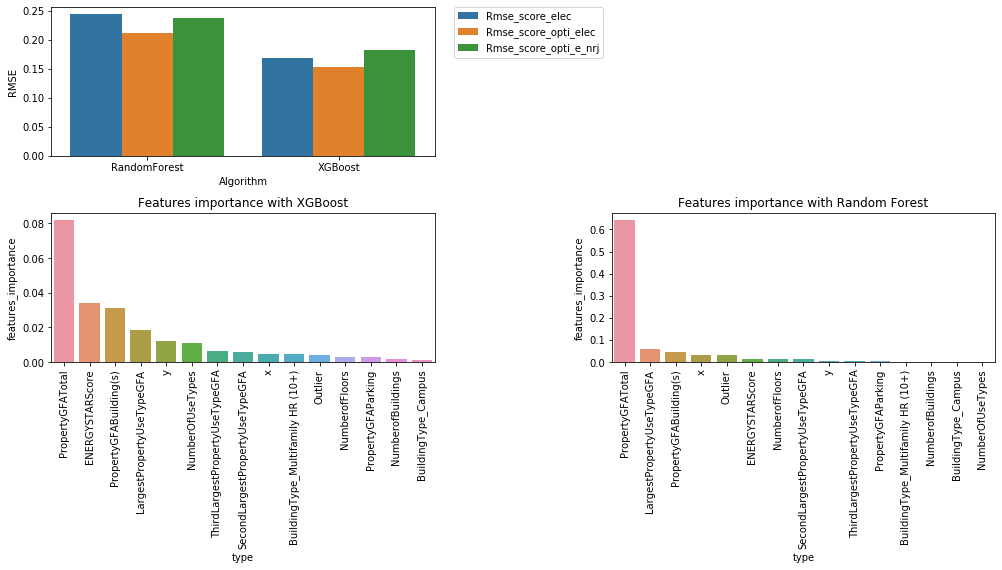

In [70]:
#Compare results
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

tidy2 = res.melt(id_vars='Algorithm').rename(columns=str.title)
tidy2.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy2, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(f"{(res.Rmse_score_opti_e_nrj[0]/res.Rmse_score_opti_elec[0])*100-100:.2f} % increase in RMSE without the ENERYSTARSCORE with a Random Forest")
print(f"{(res.Rmse_score_opti_e_nrj[1]/res.Rmse_score_opti_elec[1])*100-100:.2f} % increase in RMSE without the ENERYSTARSCORE with a XGBoost")

d1 = pd.DataFrame(xgb_optie.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d2 = pd.DataFrame(rfr_optie.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d1['type'] = d1.index
d1.columns=['features_importance','type']

d2['type'] = d2.index
d2.columns=['features_importance','type']

g1 = sns.barplot(x='type',y='features_importance',data=d1,ax=ax2)
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax2.set_title('Features importance with XGBoost')

g2 = sns.barplot(x='type',y='features_importance',data=d2,ax=ax3)
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax3.set_title('Features importance with Random Forest')

plt.tight_layout(pad=1)

## CO2

In [34]:
#Influence on the Electricity
X_train_c = X_train1.drop(columns="ENERGYSTARScore")
X_test_c = X_test1.drop(columns="ENERGYSTARScore")

std_scaler3 = preprocessing.StandardScaler()
X_train_stdc = std_scaler3.fit_transform(X_train_c)
X_test_stdc = std_scaler3.transform(X_test_c)

xgb_optic.fit(X_train_stdc,y_train1)

rfr_optic.fit(X_train_stdc,y_train1)

RMSE_score_opti_c_nrj = []

RMSE_score_opti_c_nrj.append(metrics.mean_squared_error(y_test1,rfr_optic.predict(X_test_stdc)))
RMSE_score_opti_c_nrj.append(metrics.mean_squared_error(y_test1,xgb_optic.predict(X_test_stdc)))

res1["Rmse_score_opti_c_nrj"] = RMSE_score_opti_c_nrj

1.94 % increase in RMSE without the ENERYSTARSCORE with a Random Forest
7.53 % increase in RMSE without the ENERYSTARSCORE with a XGBoost


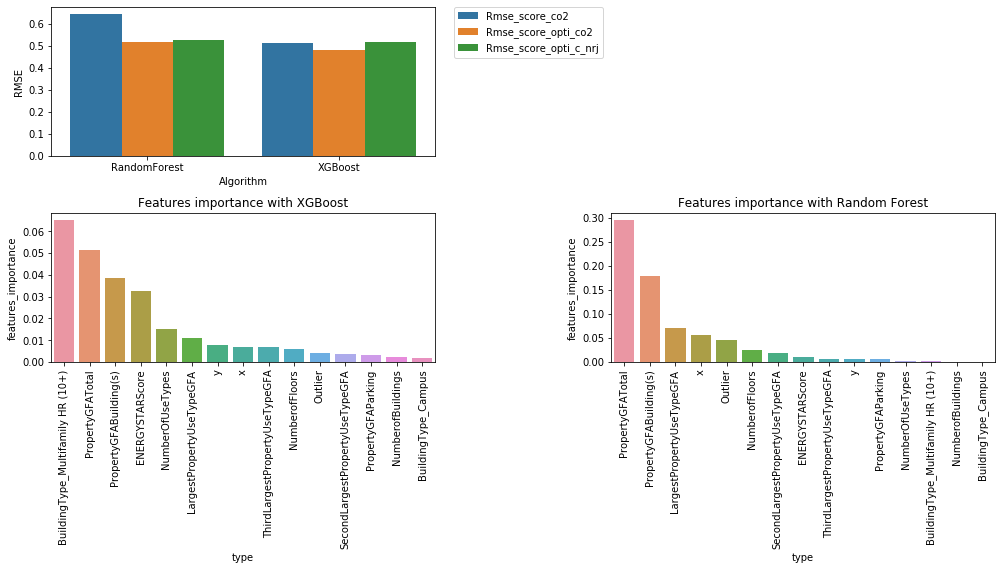

In [71]:
#Compare results
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

tidy3 = res1.melt(id_vars='Algorithm').rename(columns=str.title)
tidy3.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy3, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(f"{(res1.Rmse_score_opti_c_nrj[0]/res1.Rmse_score_opti_co2[0])*100-100:.2f} % increase in RMSE without the ENERYSTARSCORE with a Random Forest")
print(f"{(res1.Rmse_score_opti_c_nrj[1]/res1.Rmse_score_opti_co2[1] )*100-100:.2f} % increase in RMSE without the ENERYSTARSCORE with a XGBoost")

d1 = pd.DataFrame(xgb_optic.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d2 = pd.DataFrame(rfr_optic.feature_importances_[:15],index=X_train.columns[:15]).sort_values(
    by=0,ascending=False)

d1['type'] = d1.index
d1.columns=['features_importance','type']

d2['type'] = d2.index
d2.columns=['features_importance','type']

g1 = sns.barplot(x='type',y='features_importance',data=d1,ax=ax2)
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax2.set_title('Features importance with XGBoost')

g2 = sns.barplot(x='type',y='features_importance',data=d2,ax=ax3)
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax3.set_title('Features importance with Random Forest')

plt.tight_layout(pad=1)

# PCA

As we noticed in the previous notebook, several features are highly correlated, so using a dimension reduction algorithm such as PCA which could remove the correlated features could improve the result.

In [36]:
pca = decomposition.PCA(svd_solver='auto')

X_train_pca = pd.DataFrame(pca.fit_transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))

# Eigenvalues of covariance matrix (X_train) sorted desc:
eig_values = pd.DataFrame(pca.explained_variance_ratio_)
eig_values['explained_var'] = eig_values.cumsum()*100
eig_values.drop(columns=0,inplace=True)

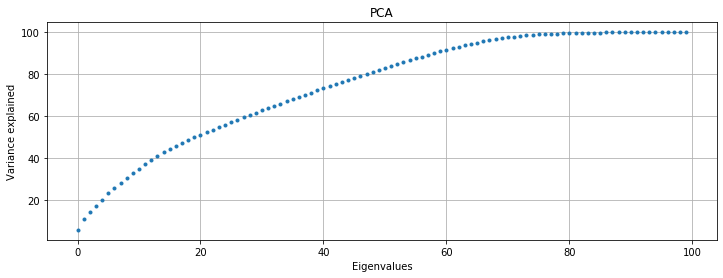

In [37]:
#Plot the eigen values
plt.figure(figsize=(12,4))
plt.grid()
# plt.plot(np.log(eig_values.abs().values),'.')
plt.plot((eig_values.abs().values),'.')
# plt.xticks(np.arange(X_train_std.shape[1]),rotation=90)
# plt.vlines(x=27.5, ymin=0, ymax=0.2, colors='r', linestyles='--')
plt.title('PCA')
plt.ylabel('Variance explained')
plt.xlabel('Eigenvalues')
plt.show()

In [38]:
pca1 = decomposition.PCA(svd_solver='auto', n_components=60)

X_train_pca1 = pd.DataFrame(pca1.fit_transform(X_train_std))
X_test_pca1 = pd.DataFrame(pca1.transform(X_test_std))

In [39]:
clf_pca = XGBRegressor(objective="reg:squarederror",learning_rate=0.05, random_state=42, 
                        max_depth= 10, max_features= 0.1, min_samples_leaf= 50, n_estimators=300)

y_pred_pca = compute_output(clf_pca,X_train_pca1, y_train, X_test_pca1)
error_pca = metrics.mean_squared_error(y_test, y_pred_pca)

print(f"{error_all_rmse[-1]:.2f}: RMSE with the baseline ")
print(f"{error_pca:.2f}: RMSE with the PCA ")
print(f"{res['Rmse_score_opti_elec'][1]:.2f}: RMSE with all the features")    

0.56: RMSE with the baseline 
0.26: RMSE with the PCA 
0.15: RMSE with all the features


**Compare with all features**

In [81]:
import timeit
start = timeit.timeit()
a = compute_output(classifiers[1],X_train_std, y_train, X_test_std)
c = metrics.mean_squared_error(y_test, a)
end = timeit.timeit()
print(f"Time execution for all features: {end - start}")

start1 = timeit.timeit()
b = compute_output(clf_pca,X_train_pca1, y_train, X_test_pca1)
d = metrics.mean_squared_error(y_test, b)
end1 = timeit.timeit()
print(f"Time execution for PCA: {end1 - start1}")

Time execution for all features: 0.013234299999567156
Time execution for PCA: 0.0025105000004259637


In [82]:
print(f"The PCA is {(end-start)/(end1 - start1):.2f} times faster than with all features but {d/c*100:.2f}% less accurate.")  

The PCA is 5.27 times faster than with all features but 154.43% less accurate.


This highlights the tradeoff between processing time and accuracy. If it needed to be as fast as possible, the PCA would be a good choice, since it is 10 times faster. We will choose all features if the maximum accuracy is needed.

# Improvements

- We could have other features engineering, by using the type of energy used or the total surface of a building by multiplying the surface by the number of floors and number of buildings.   
- The CO2 emission is related to the electricity consumption. In order to improve the result on the CO2 prediction, we could use the predicted electricity to deduced the CO2 emission.

# OTHER

The CO2 emission is related to the electricity consumption. The more the electricity is used, the more CO2 it consumes. We know that we are able to predict the electricity with a very good accuracy. We will study the impact on adding the predicted electricity for the CO2 prediction.

In [45]:
# y_pred_train = classifiers[1].predict(X_train_std)
# X_train_df = pd.DataFrame(X_train_std1)
# X_train_df['Elec'] = y_pred_train

# X_test_df = pd.DataFrame(X_test_std1)
# X_test_df['Elec'] = y_pred_all[1]

In [46]:
# xgb_optic.fit(X_train_df,y_train1)
# y_pred_with_elec = xgb_optic.predict(X_test_df)
# rmse_with_elec = metrics.mean_squared_error(y_test1,y_pred_with_elec)

In [47]:
# rmse_with_elec